# Chest X-Ray Medical Diagnosis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
import keras.layers as l
from keras import backend as K
from keras.models import Model

from keras.models import load_model
import nih.util

In [2]:
train_df = pd.read_csv("nih/train-small.csv")
valid_df = pd.read_csv("nih/valid-small.csv")

test_df = pd.read_csv("nih/test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [3]:
labels = ["Cardiomegaly", "Emphysema", "Effusion", "Hernia", "Infiltration",
         "Mass", "Nodule", "Atelectasis", "Pneumothorax", "Pleural_Thickening",
         "Pneumonia", "Fibrosis", "Edema", "Consolidation"]

#### Data Leakage
Make sure there are no patients in the test set that are also present in either the train or validation sets.

In [4]:
def check_for_leakage(df1, df2, patient_col):
    df1_patients_unique = set(df1[patient_col].unique())
    df2_patients_unique = set(df2[patient_col].unique())
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    
    leakage = len(patients_in_both_groups) > 0
    
    return leakage

In [5]:
print("leakage between train and valid: {}".format(check_for_leakage(train_df, valid_df, 'PatientId')))
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and valid: True
leakage between train and test: False
leakage between valid and test: False


### Preparing pictures
We use the generator to transform the values in each batch so that their mean is 0 and their standard deviation is 1.

This will facilitate model training by standarizing the input distribution.

The generator also converts our single channel X-ray immages (grayscale) to a 3 channel format by repeating the values in the image across all channels.

In [6]:
def get_train_generator(df, image_dir, x_col, y_col, shuffle=True, batch_size=8,
                       seed=1, target_w=320, target_h=320):
    print("getting train generator...") 
    
#     normalize images
    image_generator = ImageDataGenerator(
                        samplewise_center=True,
                        samplewise_std_normalization=True)
    
    generator = image_generator.flow_from_dataframe(
        dataframe=df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_col,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed,
        target_size=(target_w, target_h)
    )
    
    return generator

In [7]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_col,
                                sample_size=100, batch_size=8, seed=1, target_w=320,
                                 target_h=320):
    print("getting train and valid generators...")
    
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image",
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))
    
    batch = raw_train_generator.next()
    data_sample = batch[0]
    
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True
    )
    
    image_generator.fit(data_sample)
    
    valid_generator = image_generator.flow_from_dataframe(
        dataframe=valid_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_col,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w, target_h)
    )
    
    test_generator = image_generator.flow_from_dataframe(
        dataframe=test_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_col,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w, target_h)
    )
    
    return valid_generator, test_generator

In [8]:
IMAGE_DIR = "nih/images_small/"

train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df,
                                                              IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


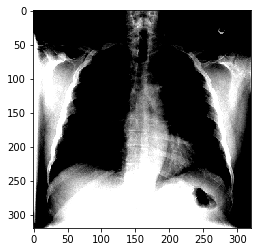

In [9]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])

### Addressing Class Imbalance

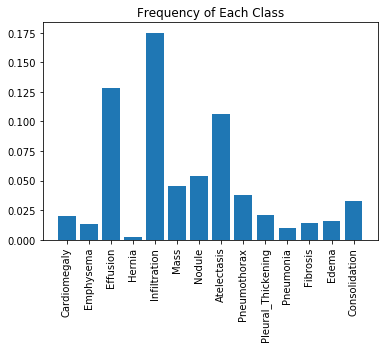

In [10]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

#### Impact of class imbalance on loss function
Assume we would have used a normal crossentropy loss for each pathology. We recall that the crossentropy loss contribution from the $i^{th}$  training case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

Where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive.

Note that for any training case, either $y_i = 0$ or else $(1 0 y_i) = 0$, so only one of these terms contributes to the loss (the other term is multiplied by zero and becomes zero).



We can rewritee the overall crossentropy loss over the entire training set $D$ of size $N$ as follows:

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class.

Summoning the cntribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is:

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

### Computing Class Frequence
Calculating frequencies for each label in our dataset.

In [11]:
def compute_class_freqs(labels):
    N = len(labels)
    
    positive_freq = np.sum(labels, axis=0) / N
    negative_freq = np.sum(1 - labels, axis=0) / N
    
    return positive_freq, negative_freq

In [12]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

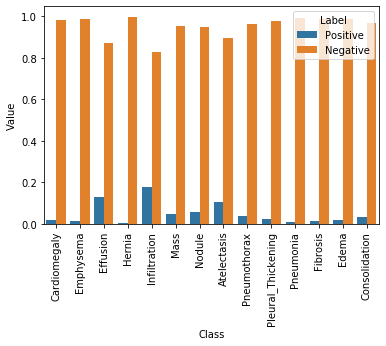

In [13]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                    for l, v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)

As we see in the above plot, the contribution of positive cases is significantly lower than that of the negative ones.

However, we want the contributions to be equal.

One way of ding this is by multiplying each example from each class by a class-specific weight factor $w_pos$ and $w_neg$, so that the overall contribution of each class is the same.

To have this, we want:
$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [14]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

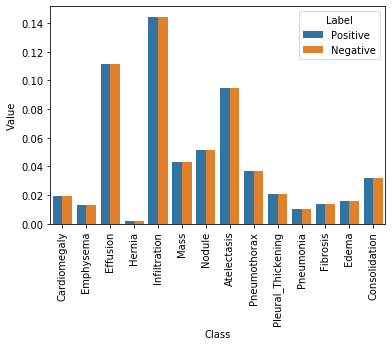

In [15]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                    for l, v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function.

Now let's implement such a loss function.

After computing the weights, our final weighted loss for each training case will be:

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [16]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_preds):
        loss = 0.0
        
        for i in range(len(pos_weights)):
            loss_pos = -K.mean(pos_weights[i] * y_true[:, i] * K.log(y_preds[:, i] + epsilon))
            loss_neg = -K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_preds[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss.numpy()
    
    return weighted_loss

### DenseNet121
We can set our cutom loss function for the model by specifying the `loss` parameter in the `compile()` function

In [17]:
base_model = DenseNet121(weights='nih/densenet.hdf5', include_top=False)

x = base_model.output

x = l.GlobalAveragePooling2D()(x)

predictions = l.Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer="adam", loss="categorical_crossentropy")

In [18]:
history = model.fit_generator(train_generator,
                             validation_data=valid_generator,
                             steps_per_epoch=100,
                             validation_steps=25,
                             epochs=3)

R:\Work\Anacond\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
100/100 [==============================] - 210s 942ms/step - loss: 1.6803 - val_loss: 73.2907
Epoch 2/3
100/100 [==============================] - 57s 568ms/step - loss: 1.4905 - val_loss: 25.2169
Epoch 3/3
100/100 [==============================] - 85s 846ms/step - loss: 1.6127 - val_loss: 8.1621


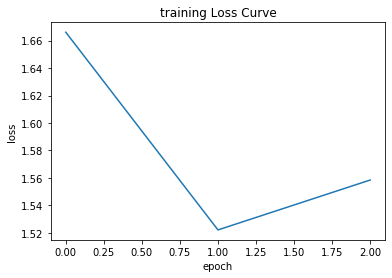

In [19]:
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("training Loss Curve")
plt.show()

In [ ]:
predicted_vals = model.predict_generator(test_generator, steps=len(test_generator))

R:\Work\Anacond\lib\site-packages\keras\engine\training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
predicted_vals

### ROC Curve

In [ ]:
auc_rocs = nih.util.get_roc_curve(labels, predicted_vals, test_generator)

In [ ]:
model.load_weights("nih/pretrained_model.h5")

In [ ]:
predicted_vals = model.predict_generator(test_generator, steps=len(test_generator))

In [ ]:
predicted_vals

In [ ]:
auc_rocs = nih.util.get_roc_curve(labels, predicted_vals, test_generator)

### GradCAM
One of the most common approaches aimed at increasing the interpretability of models for computer vision tasks is to use Class Activation Maps (CAM).

In this section we will use a GradCAM's technique to produce a heatmap highlighting the important regions in the image for predicting the pathological condition.

In [ ]:
df = pd.read_csv("nih/train-small.csv")
IMAGE_DIR = "nih/images_small/"

labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [94]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity
from tensorflow.keras.backend import gradients
import tensorflow as tf


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """GradCAM method for visualizing input saliency."""
    with tf.GradientTape() as tape:
        y_c = input_model.output[0, cls]
        conv_output = input_model.get_layer(layer_name).output
    grads = tape.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1

def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std



In [95]:
compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

ValueError: Calling `Model.predict` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.predict` with eager mode enabled.

In [ ]:
nih.util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)